In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [55]:
def data_load(dsets, batch_size):
    mnist_train = dsets.FashionMNIST(root='data',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

    mnist_test = dsets.FashionMNIST(root='data',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)
    
    # dataset loader
    traindata_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)
    
    testdata_loader = DataLoader(dataset=mnist_train,
                                        batch_size=batch_size, # 배치 크기는 100
                                        shuffle=True,
                                        drop_last=True)


    return mnist_train, mnist_test, traindata_loader, testdata_loader

In [56]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim))
    
    def forward(self, x):
        x_flatten = self.flatten(x)
        logits = self.linear_relu_stack(x_flatten)
        return logits

In [57]:
def model_setting(input_dim, output_dim, device):

    # 비용 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
    model = NeuralNetwork(input_dim, output_dim).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return criterion, model, optimizer

In [58]:
def training(training_epochs, data_loader, criterion, model, optimizer, device):
    model.train() # 모델을 학습 모드로 
    for one_epoch in range(training_epochs):

        total_batch = len(data_loader)
        avg_cost = 0
        
        for x_train, y_train in data_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            model_output = model(x_train)
            
            cost = criterion(model_output, y_train) ## CrossEntropyLoss
            cost.backward()
            optimizer.step()
            avg_cost += cost / total_batch

        print(f"Epoch : {one_epoch+1} / {training_epochs}, cost : {avg_cost:.4f}")

    return model 

In [59]:
if __name__ == "__main__":

    # check GPU 
    USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
    device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
    print("다음 기기로 학습합니다:", device)

    # for reproducibility
    random.seed(777)
    torch.manual_seed(777)
    if device == 'cuda': torch.cuda.manual_seed_all(777)

    # model hyperparameters
    training_epochs = 20
    batch_size = 64

    mnist_train, mnist_test, traindata_loader, testdata_loader = data_load(dsets, batch_size)
    input_dim, output_dim = mnist_train.data.shape[-1] * mnist_train.data.shape[-2], 10
    criterion, model, optimizer = model_setting(input_dim, output_dim, device)
    model = training(training_epochs, traindata_loader, criterion, model, optimizer, device)

다음 기기로 학습합니다: cuda
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch : 1 / 20, cost : 0.4925
Epoch : 2 / 20, cost : 0.3608
Epoch : 3 / 20, cost : 0.3229
Epoch : 4 / 20, cost : 0.2951
Epoch : 5 / 20, cost : 0.2786
Epoch : 6 / 20, cost : 0.2623
Epoch : 7 / 20, cost : 0.2467
Epoch : 8 / 20, cost : 0.2383
Epoch : 9 / 20, cost : 0.2272
Epoch : 10 / 20, cost : 0.2159
Epoch : 11 / 20, cost : 0.2070
Epoch : 12 / 20, cost : 0.1962
Epoch : 13 / 20, cost : 0.1896
Epoch : 14 / 20, cost : 0.1805
Epoch : 15 / 20, cost : 0.1743
Epoch : 16 / 20, cost : 0.1702
Epoch : 17 / 20, cost : 0.1615
Epoch : 18 / 20, cost : 0.1544
Epoch : 19 / 20, cost : 0.1509
Epoch : 20 / 20, cost : 0.1423


In [62]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for x_test, y_test in testdata_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(y_test.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(testdata_loader.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,  data_num, 100. * correct / data_num))


In [63]:
test()


테스트 데이터에서 예측 정확도: 56943/60000 (95%)



Label:  4
Prediction:  4


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


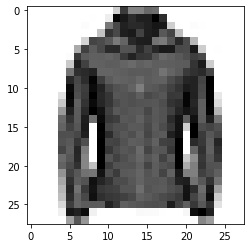

In [65]:
# MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()